# Post-Up Performance EDA and Model
In this notebook, I will explore the relationships of different player stats and their expected value on future post-ups.  

Goals:
- Look for what stats might best predict post-up performance.
- Find the best model to make accurate predictions.

Conclusions:  
- Post-up performance is extremely difficult to predict due to small amount of players who do it.
- Passing ability (assist to turnover ratio) is the most important predictor.
- Free throw percentage and scoring with tight coverage were also important predictors.
- The year was important. This may have to do with trends in the league and/or recent player skillsets.

## 0. Importing Libraries and Data

In [2]:
# Importing standard libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Importing SKlearn libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import SelectKBest, RFECV, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping
# Importing created functions
from dictionaries import stat_types
from df_functions import use_history
from model_prep import corr_finder, data_split, feature_selection_corr, shift_data
from graphing import corr_plots, box_plots

In [3]:
# Importing data
master_df = pd.read_csv('./data/master_df', index_col=0)

## 1. Create Train, Validate, and Test Sets
#### Create X and y

In [4]:
# Saving the data for all player seasons where they had at least 50 post-ups
post_index = master_df[(master_df['POST_TOUCHES'] * master_df['GP']) >= 50].index
data = master_df.loc[post_index]

In [5]:
# Matching player data with the target data in the following year
data = shift_data(data, 'PLAYER_ID', ['POST_TOUCH_EV'])

In [6]:
# Setting up the initial X and y
y = data.loc[:, ['TARGET_POST_TOUCH_EV']]
X = data.drop(columns='TARGET_POST_TOUCH_EV')

#### Splitting X and y into train, validate, and test sets

In [7]:
# Creating the train, validate, and test sets for post-up expected value
X_train, X_validate, X_test, y_train, y_validate, y_test = data_split(X, y, 'POST_TOUCH_EV')

## 2. Determine Potential Features
- Features used to calculate expected value (free throw percentage, turnovers, and shooting) are correlated with future performance.
- There is a slight increase each year in effectiveness. I wonder if this is related to the increase value of an assist each year.

#### Finding correlated features

In [8]:
# Saving a list of possible numerical features
numeric_columns = list(data.dropna(axis=1).select_dtypes(['float', 'int']).columns)
numeric_columns.remove('TEAM_ID')
numeric_columns.remove('PLAYER_ID')
numeric_columns.remove('2018')

In [9]:
# Looking for features with the highest correlation with the target
corr_features = corr_finder(X_train[numeric_columns], y_train, .3, 10)

In [10]:
# Looking at the most correlated features with the target
corr_features

['AST_TO',
 'AST_TO_WEIGHTED',
 'PAINT_TOUCHES_PER_MIN',
 'PAINT_TOUCHES_PER_MIN_WEIGHTED',
 'PAINT_TOUCH_FGM_PER_MIN_WEIGHTED',
 'PAINT_TOUCH_FGA_PER_MIN_WEIGHTED',
 'PAINT_TOUCH_FGA_PER_MIN',
 'FT_PCT',
 'PAINT_TOUCH_FGM_PER_MIN',
 'OREB_PER_MIN']

In [11]:
# Finding the most correlated features that are not correlated with each other
corr_features = feature_selection_corr(X_train[numeric_columns], y_train['TARGET_POST_TOUCH_EV'], alpha=.3)

#### Graphing correlated features

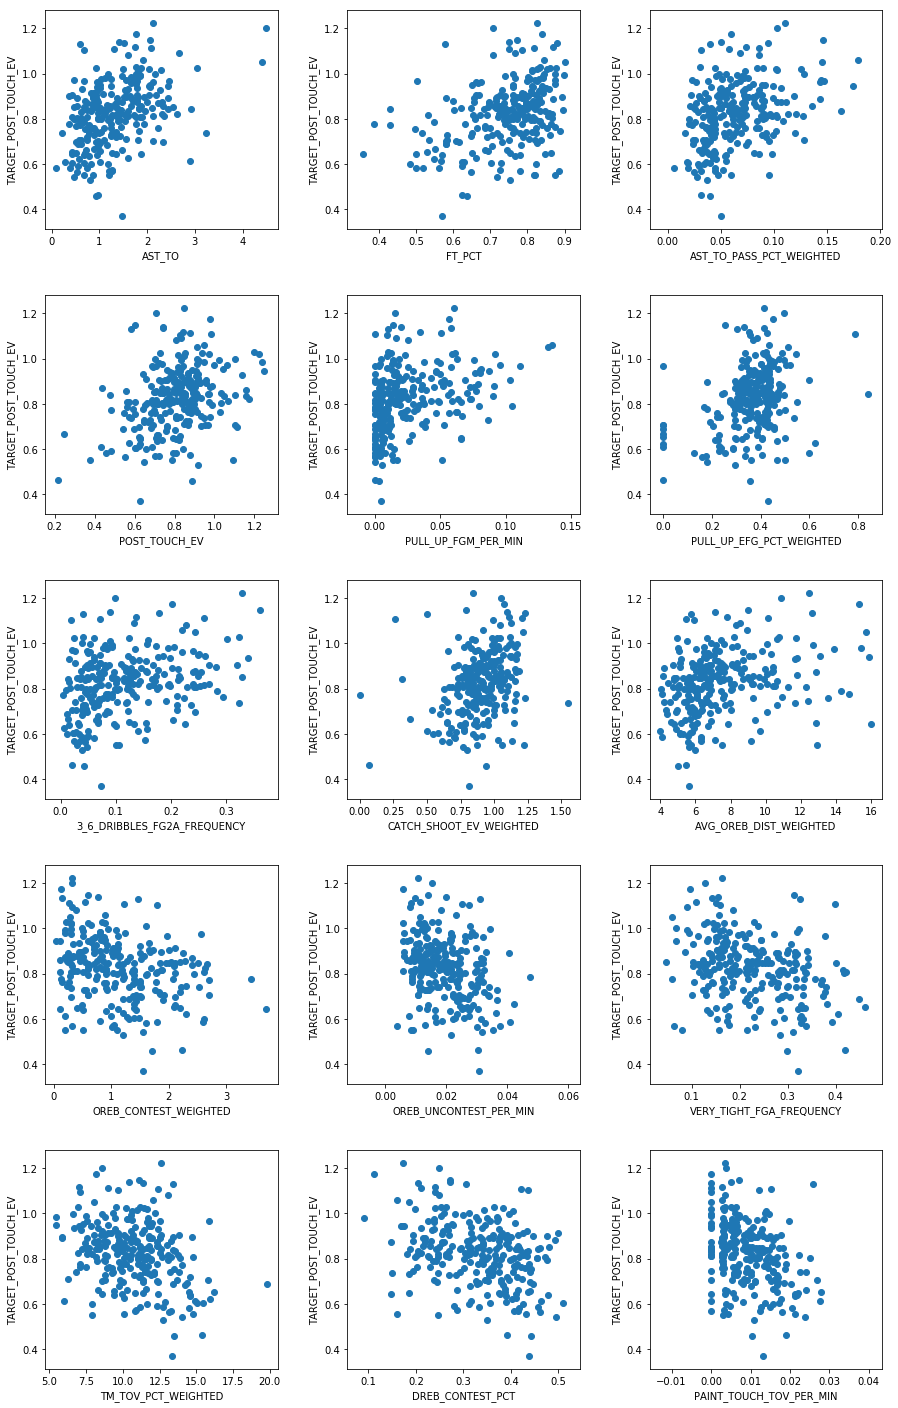

In [12]:
# Plotting those features
corr_plots(X_train, y_train, corr_features);

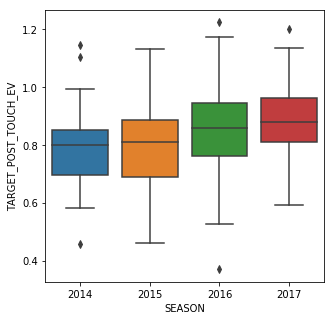

In [13]:
box_plots(X_train, y_train, ['SEASON'], cols=1)

## 3. Modeling

#### RFECV
- Used 5 features.
- Did not perform very well.

In [14]:
# Using recursive feature elimination to attempt to select features for the model
model = LinearRegression()
kfolds = KFold(n_splits=5, shuffle=True)
rfecv = RFECV(estimator=model, step=1, cv=kfolds)
rfecv.fit(X_train[numeric_columns], y_train.iloc[:,0])
rfecv.n_features_

5

In [15]:
# Checking which features were selected
X_train[numeric_columns].columns[rfecv.get_support(indices=True)]

Index(['VERY_OPEN_FGA_PER_MIN', 'VERY_OPEN_FG2A_PER_MIN',
       'VERY_OPEN_FG3M_PER_MIN', 'VERY_OPEN_FG3A_PER_MIN',
       'TIGHT_EFG_PCT_WEIGHTED'],
      dtype='object')

In [16]:
# Checking out the score with the validation data
rfecv.score(X_validate[numeric_columns], y_validate)

0.005237192732281181

#### K BEST
- The 8 feature model seemed the best. It had a lower variance in the cross validation, high cross validation scores, and it had one of the best scores with the validation set.
- There is a slight tendency for lower than average predicted scores to be too high and higher than average predicted scores to be too low.

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_select

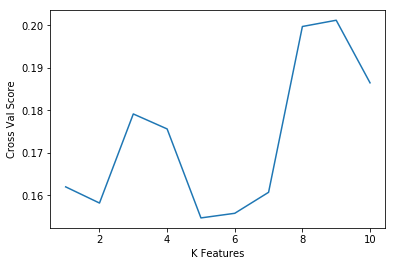

In [17]:
# Looping to select the best k for select k best feature selection
k_scores = []
for k in range(1, 11):
    
    # Finding the best features for a given k
    k_best = SelectKBest(f_regression, k=k)
    k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
    model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
    
    # Appending cross val scores for those features
    model = LinearRegression()
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    k_scores.append(cross_val_score(model, X_train[model_features], y_train, cv=kfolds).mean())
    
plt.plot(range(1,11), k_scores)
plt.xlabel('K Features')
plt.ylabel('Cross Val Score');

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_select

1  Feature Cross Val Scores:  [0.02374381 0.28376934 0.12919876 0.21905713 0.15436992]
2  Feature Cross Val Scores:  [0.02267467 0.27278862 0.12670195 0.21466173 0.15427923]
3  Feature Cross Val Scores:  [0.0934397  0.31597894 0.07584916 0.22740412 0.18316825]
4  Feature Cross Val Scores:  [0.09464175 0.31870404 0.07072858 0.2282065  0.16594486]
5  Feature Cross Val Scores:  [0.09282208 0.2841192  0.02447469 0.21455404 0.15765373]
6  Feature Cross Val Scores:  [0.07313114 0.27777261 0.03741783 0.22644918 0.16428651]
7  Feature Cross Val Scores:  [0.07117819 0.28916817 0.04296389 0.21883858 0.18158971]
8  Feature Cross Val Scores:  [0.10866252 0.30185206 0.15648785 0.24673824 0.18490261]
9  Feature Cross Val Scores:  [0.11769328 0.30541302 0.1428275  0.25596488 0.18410035]


/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


10  Feature Cross Val Scores:  [0.11793795 0.30481237 0.11340406 0.21347283 0.18280539]


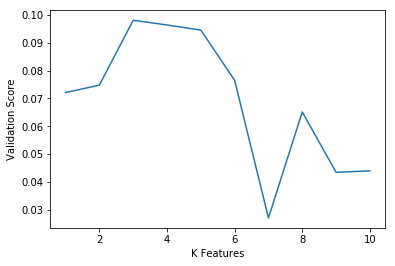

In [19]:
# Checking out 1 - 10 features
k_scores = []
for k in range(1, 11):
    
    # Finding the best features for a given k
    k_best = SelectKBest(f_regression, k=k)
    k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
    model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
    
    # Appending the validation scores
    model = LinearRegression()
    model.fit(X_train[model_features], y_train)
    k_scores.append(model.score(X_validate[model_features], y_validate))
    
    # Printing out the cross val scores
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    print(k, ' Feature Cross Val Scores: ', cross_val_score(model, X_train[model_features], y_train, cv=kfolds))
    
# Graphing the validations scores
plt.plot(range(1, 11), k_scores)
plt.xlabel('K Features')
plt.ylabel('Validation Score');

In [35]:
# Printing out the scores with 8 features
k_best = SelectKBest(f_regression, k=8)
k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
model.fit(X_train[model_features], y_train)
model.score(X_validate[model_features], y_validate)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


0.0651072041245796

In [36]:
# Printing the model features
model_features

['AST_TO',
 'FT_PCT',
 'PAINT_TOUCHES_PER_MIN',
 'PAINT_TOUCH_FGA_PER_MIN',
 'AST_TO_WEIGHTED',
 'PAINT_TOUCHES_PER_MIN_WEIGHTED',
 'PAINT_TOUCH_FGM_PER_MIN_WEIGHTED',
 'PAINT_TOUCH_FGA_PER_MIN_WEIGHTED']

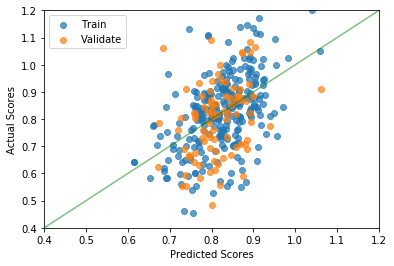

In [37]:
# Plotting the predicted versus actual scores for the training and validation sets
plt.scatter(model.predict(X_train[model_features]), y_train, label='Train', alpha=.7)
plt.scatter(model.predict(X_validate[model_features]), y_validate, label='Validate', alpha=.7)
plt.plot([.4,1.2], [.4,1.2], color='g', alpha=.5)
plt.xlim(.4,1.2)
plt.ylim(.4,1.2)
plt.xlabel('Predicted Scores')
plt.ylabel('Actual Scores')
plt.legend();

#### PCA.
- The model was had some concerning variance in the cross validation.
- 2 features seemed optimal using the elbow method.

In [20]:
# Fitting PCA and checking the explained variance
pca = PCA(n_components=15)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_columns])
X_validate_scaled = scaler.transform(X_validate[numeric_columns])
pca.fit(X_train_scaled)
explained_var = pca.explained_variance_ratio_
explained_var

array([0.29744777, 0.17033575, 0.07051126, 0.05115521, 0.04074574,
       0.02998744, 0.02637841, 0.02481237, 0.01965087, 0.01871216,
       0.01464643, 0.01349419, 0.01151573, 0.01038791, 0.00948063])

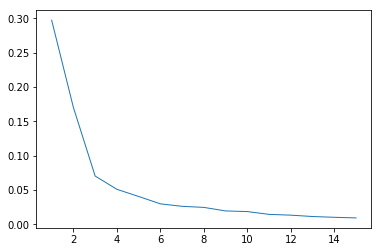

In [21]:
# Looking at the graph of explained variance and looking for the "elbow"
plt.plot(range(1, len(explained_var) + 1), explained_var, lw=1);

In [22]:
# Looking at the cross val score
pca = PCA(n_components=2)
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
model = LinearRegression()
cross_val_score(model, pca.fit_transform(X_train_scaled), y_train, cv=kfolds)

array([ 0.1345865 ,  0.03740419, -0.01875739,  0.11458583,  0.20746492])

In [23]:
# Seeing the score on the validation set
model.fit(pca.transform(X_train_scaled), y_train)
model.score(pca.transform(X_validate_scaled), y_validate)

0.14351380270942882

#### Neural Net
- The neural net struggled to differentiate between players.

In [24]:
# Preparing a neural net with all possible features
model_features = data[numeric_columns].dropna(axis=1).columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[model_features])
X_validate_scaled = scaler.transform(X_validate[model_features])

In [25]:
# Creating the neural net
model = Sequential()
model.add(Dense(len(model_features), activation='relu', input_dim=len(model_features)))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/2), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/4), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/8), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/16), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/32), activation='relu', kernel_regularizer=regularizers.l2(.01)))
model.add(Dense(1, activation=None))

In [26]:
# Compiling the neural net and setting an early stopping feature
model.compile(loss='mean_squared_error', optimizer='adam')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=50)

In [27]:
# Fitting the neural net
model.fit(X_train_scaled, y_train, validation_data=(X_validate_scaled, y_validate),epochs=1000,
          callbacks=[early], verbose=0);

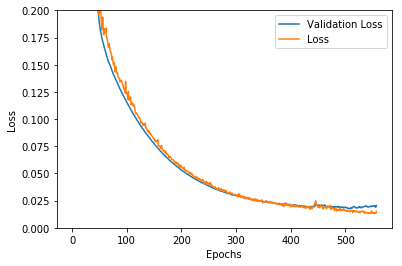

In [28]:
# Plotting the loss over epochs while training
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.plot(model.history.history['loss'], label='Loss')
plt.ylim(0,.2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

In [29]:
# Finding the r2 score on the validation set
r2_score(y_validate, model.predict(X_validate_scaled))

-0.06183254222922918

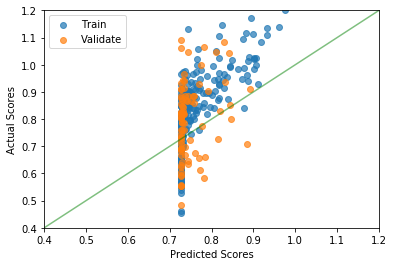

In [30]:
# Plotting the predicted versus actual scores for the training and validation sets
plt.scatter(model.predict(X_train_scaled), y_train, label='Train', alpha=.7)
plt.scatter(model.predict(X_validate_scaled), y_validate, label='Validate', alpha=.7)
plt.plot([.4,1.2], [.4,1.2], color='g', alpha=.5)
plt.xlim(.4,1.2)
plt.ylim(.4,1.2)
plt.xlabel('Predicted Scores')
plt.ylabel('Actual Scores')
plt.legend();

#### Linear Regression with My Selected Features
- These features are based on correlations that I saw, features that go into expected value, and features that I wanted to experiment with.
- The scores had a high variance in the cross-validation and did even worse with the validation set.
- There is the same problem of under predicting "extreme" cases.

In [31]:
# Saving the model features
model_features = ['OPEN_FG2_PCT_WEIGHTED', 'FT_PCT_WEIGHTED', 'POST_TOUCH_AST_PCT_WEIGHTED',
                  'POST_TOUCH_FGA_PCT', 'POST_TOUCH_TOV_PCT_WEIGHTED', 'POST_TOUCH_PTS_PCT_WEIGHTED',
                  'POST_TOUCH_RATE_WEIGHTED', 'PLAYER_HEIGHT_INCHES', 'SKINNY', 'AGE', '2015', '2016', '2017',
                  'AST_TO_WEIGHTED', 'TIGHT_FG2_PCT_WEIGHTED', 'VERY_TIGHT_FG2_PCT']

In [34]:
# Finding the cross validation score
model = LinearRegression()
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_score(model, X_train[model_features], y_train, cv=kfolds)

array([0.28397097, 0.2534756 , 0.35600452, 0.0902302 , 0.07641821])

In [33]:
# Checking the validation score
model.fit(X_train[model_features], y_train)
model.score(X_validate[model_features], y_validate)

0.03656887723243507

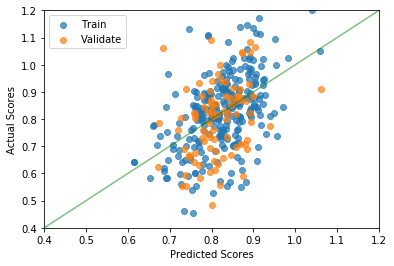

In [38]:
# Plotting the predicted versus actual scores for the training and validation sets
plt.scatter(model.predict(X_train[model_features]), y_train, label='Train', alpha=.7)
plt.scatter(model.predict(X_validate[model_features]), y_validate, label='Validate', alpha=.7)
plt.plot([.4,1.2], [.4,1.2], color='g', alpha=.5)
plt.xlim(.4,1.2)
plt.ylim(.4,1.2)
plt.xlabel('Predicted Scores')
plt.ylabel('Actual Scores')
plt.legend();

#### Regularized Linear Regression with My Selected Features
- These scores are much improved from the linear regression.
- The ridge predictions are very narrow.
- They both suffer from having the same over and under predicting problem as the other models.
- They both really valued assist to turnover values and free throw percentage.

In [39]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[model_features])
X_validate_scaled = scaler.transform(X_validate[model_features])

In [40]:
# Testing out ridge regression
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
ridge_cv = RidgeCV(alphas=np.logspace(-1,3,100), cv=kfolds)
ridge_cv.fit(X_train_scaled, y_train)
ridge = Ridge(alpha=ridge_cv.alpha_)
cross_val_score(ridge, X_train_scaled, y_train, cv=kfolds)

array([0.1246157 , 0.31297937, 0.1510086 , 0.29307311, 0.18248112])

In [41]:
# Seeing the score on the validation set
ridge.fit(X_train_scaled, y_train)
ridge.score(X_validate_scaled, y_validate)

0.1332218591366594

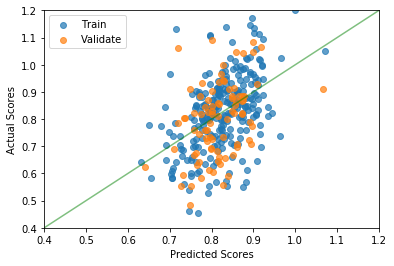

In [42]:
# Plotting the predicted versus actual scores for the training and validation sets
plt.scatter(ridge.predict(X_train_scaled), y_train, label='Train', alpha=.7)
plt.scatter(ridge.predict(X_validate_scaled), y_validate, label='Validate', alpha=.7)
plt.plot([.4,1.2], [.4,1.2], color='g', alpha=.5)
plt.xlim(.4,1.2)
plt.ylim(.4,1.2)
plt.xlabel('Predicted Scores')
plt.ylabel('Actual Scores')
plt.legend();

In [43]:
# Testing out lasso regression
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
lasso_cv = LassoCV(alphas=np.linspace(.01,1,100), cv=kfolds)
lasso_cv.fit(X_train_scaled, y_train)
lasso = Lasso(alpha=lasso_cv.alpha_)
cross_val_score(lasso, X_train_scaled, y_train, cv=kfolds)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.11672791, 0.31801771, 0.1628076 , 0.28139883, 0.17508765])

In [44]:
# Seeing the score on the validation set
lasso.fit(X_train_scaled, y_train)
lasso.score(X_validate_scaled, y_validate)

0.12708889660819234

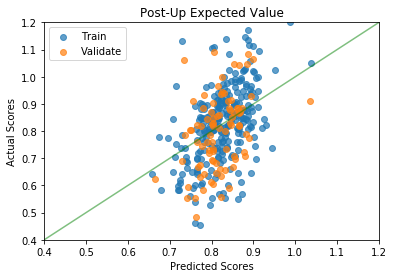

In [45]:
# Plotting the predicted versus actual scores for the training and validation sets
plt.scatter(lasso.predict(X_train_scaled), y_train, label='Train', alpha=.7)
plt.scatter(lasso.predict(X_validate_scaled), y_validate, label='Validate', alpha=.7)
plt.plot([.4,1.2], [.4,1.2], color='g', alpha=.5)
plt.xlim(.4,1.2)
plt.ylim(.4,1.2)
plt.xlabel('Predicted Scores')
plt.ylabel('Actual Scores')
plt.legend()
plt.title('Post-Up Expected Value');

In [47]:
# Looking at the selected features
lasso_coefs = pd.DataFrame(lasso.coef_, index=model_features, columns=['LASSO'])
ridge_coefs = pd.DataFrame(ridge.coef_, columns=model_features, index=['RIDGE']).T
pd.concat([lasso_coefs, ridge_coefs], axis=1)

,LASSO,RIDGE
AST_TO,0.033336,0.022704
FT_PCT,0.026767,0.029000
PAINT_TOUCHES_PER_MIN,-0.010003,-0.009914
PAINT_TOUCH_FGA_PER_MIN,-0.000000,0.000637
AST_TO_WEIGHTED,0.000000,0.014309
PAINT_TOUCHES_PER_MIN_WEIGHTED,-0.000000,-0.006207
PAINT_TOUCH_FGM_PER_MIN_WEIGHTED,-0.000000,-0.001085
PAINT_TOUCH_FGA_PER_MIN_WEIGHTED,-0.000000,0.001439


#### Final scores (Ridge)
- The r2 score on the test set was reasonable compared to many of the models' cross validation scores.
- 26.8% percent improvement over baseline predictions on the test set.

In [50]:
# Ridge score on test data
X_test_scaled = scaler.transform(X_test[model_features])
ridge.score(X_test_scaled, y_test)

0.19681818521918149

In [51]:
# Root mean squared error
rmse = mean_squared_error(y_test, ridge.predict(X_test_scaled)) ** .5
rmse

0.13149335984972024

In [52]:
# The score if the prediction was just the value from the current year
baseline = mean_squared_error(y_test, X_test['POST_TOUCH_EV']) ** .5
baseline

0.17975752269153092

In [53]:
# Looking at the percent improvement
1 - rmse/baseline

0.2684959278429385

#### Looking to correct the undervaluing/overvaluing problem (Future)

In [54]:
# Creating a training set
train = pd.merge(X_train, y_train, left_index=True, right_index=True)
train['PREDICTED_POST_TOUCH_EV'] = ridge.predict(X_train_scaled)

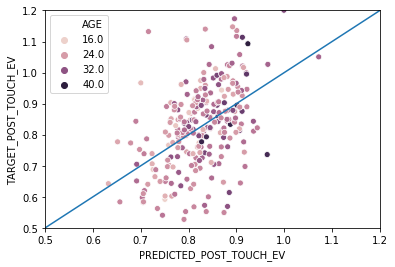

In [55]:
sns.scatterplot('PREDICTED_POST_TOUCH_EV', 'TARGET_POST_TOUCH_EV', data=train, hue='AGE')
plt.plot([0,1.2], [0,1.2])
plt.xlim(.5, 1.2)
plt.ylim(.5, 1.2);

#### Saving the predictions

In [68]:
# Loading the target dataframe
target_df = pd.read_csv('./data/target_df', index_col=0)

In [69]:
# Adding the predictions to the target dataframe
master_scaled = scaler.transform(master_df[model_features].dropna())
predictions = ridge.predict(master_scaled)
predictions_index = master_df[model_features].dropna().index
predictions_df = pd.DataFrame(predictions, columns=['PRED_POST_TOUCH_EV'], index=predictions_index)
target_df = pd.merge(target_df, predictions_df, how='left', left_index=True, right_index=True)

In [70]:
# Saving the dataframe
target_df.to_csv('./data/target_df')